In [3]:
import random
import time
from deap import base, creator, tools, algorithms
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import mlrose_hiive
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import fitness
from mlrose_hiive.runners import RHCRunner, SARunner, GARunner, MIMICRunner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import validation_curve, ValidationCurveDisplay, LearningCurveDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from concurrent.futures import ThreadPoolExecutor

In [4]:
np.random.seed(24)

In [5]:
knapsackLength = 300
knapsackWeights=np.random.uniform(5,40,knapsackLength)
knapsackValues=np.random.uniform(10,30,knapsackLength)
maxWeight_pct = 0.5
problem = mlrose_hiive.KnapsackOpt(weights=knapsackWeights, values=knapsackValues, max_weight_pct=maxWeight_pct, maximize=True)
problem.set_mimic_fast_mode(True)

In [6]:
iteration_list = [10000]
seed = 24
max_attempts = 100

In [7]:
%%time 
rhc = mlrose_hiive.RHCRunner(problem, experiment_name="rhcp", iteration_list=iteration_list,
                                       seed=seed, max_attempts=max_attempts, restart_list=[100])
rhc_run_stats, rhc_run_curves = rhc.run()

CPU times: total: 21.6 s
Wall time: 24.9 s


In [8]:
best_index_in_curve = rhc_run_curves.Fitness.idxmax()
best_decay = rhc_run_curves.iloc[best_index_in_curve].current_restart
best_curve = rhc_run_curves.loc[rhc_run_curves.current_restart == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

3.0

Text(0, 0.5, 'Value')

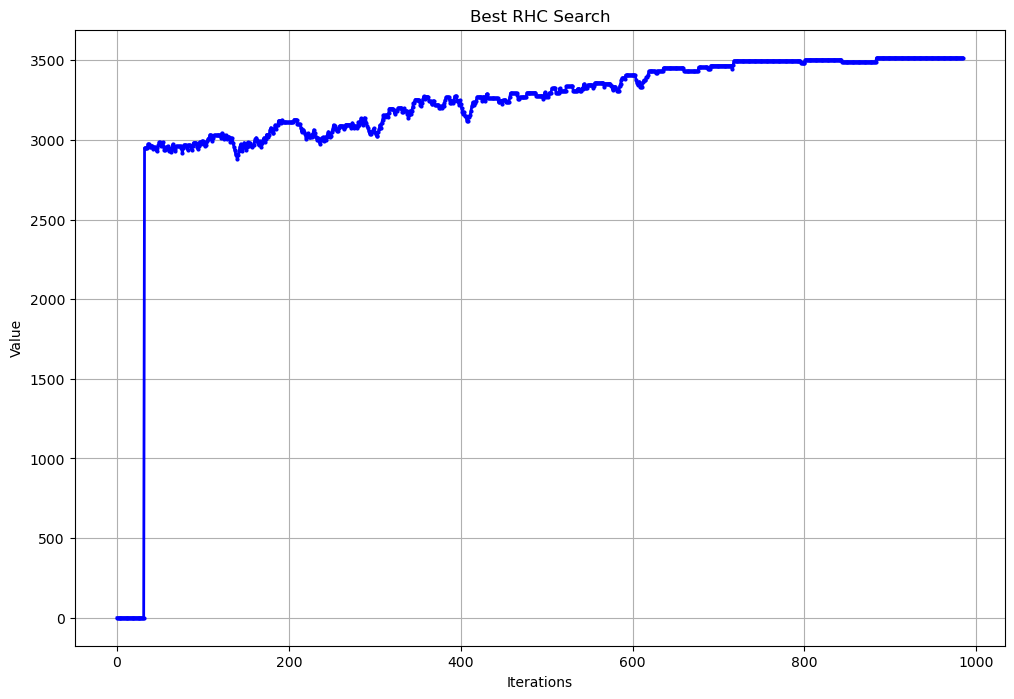

In [22]:
ax = best_curve.Fitness.plot(lw=2, colormap='winter', marker='o', markersize=2, 
                             figsize=(12,8), grid=1,
                             title='Best RHC Search')
ax.set_xlabel("Iterations")
ax.set_ylabel("Value")

In [10]:
last_iters = rhc_run_stats[rhc_run_stats.Iteration != 0].reset_index()
print(last_iters.Fitness.mean(), last_iters.Fitness.max())
print(last_iters.Time.max())

1357.8022860870997 3177.4192880630508
24.834635300037917


In [11]:
rhc_run_curves

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.000460,0.0,0.0,100,10000,0
1,1,0.005774,0.0,1.0,100,10000,0
2,2,0.005888,0.0,2.0,100,10000,0
3,3,0.006021,0.0,3.0,100,10000,0
4,4,0.006133,0.0,4.0,100,10000,0
...,...,...,...,...,...,...,...
11450,96,0.015283,0.0,11751.0,100,10000,100
11451,97,0.015367,0.0,11752.0,100,10000,100
11452,98,0.015448,0.0,11753.0,100,10000,100
11453,99,0.015530,0.0,11754.0,100,10000,100


In [12]:
%%time
sim_annealing = mlrose_hiive.SARunner(problem, experiment_name="sim_ann", 
                           iteration_list=iteration_list,
                           temperature_list=[1, 10, 50, 100, 250, 500, 1000, 2500, 5000],
                           decay_list=[mlrose_hiive.ExpDecay,
                                       mlrose_hiive.GeomDecay],
                           seed=seed, max_attempts=max_attempts)
sa_run_stats, sa_run_curves = sim_annealing.run()   

CPU times: total: 2.36 s
Wall time: 2.9 s


In [13]:
final_iterations = sa_run_stats[sa_run_stats.Iteration != 0].reset_index()

print(final_iterations.Fitness.mean(), final_iterations.Fitness.max())
print(final_iterations.Time.mean())

3236.7699286555817 3516.272755673868
0.14971963888900872


In [14]:
best_idx = sa_run_curves.Fitness.idxmax()
best_decay = sa_run_curves.iloc[best_idx].Temperature
best_curve = sa_run_curves.loc[sa_run_curves.Temperature == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

ExpDecay(init_temp=250, exp_const=0.005, min_temp=0.001)

Text(0, 0.5, 'Value')

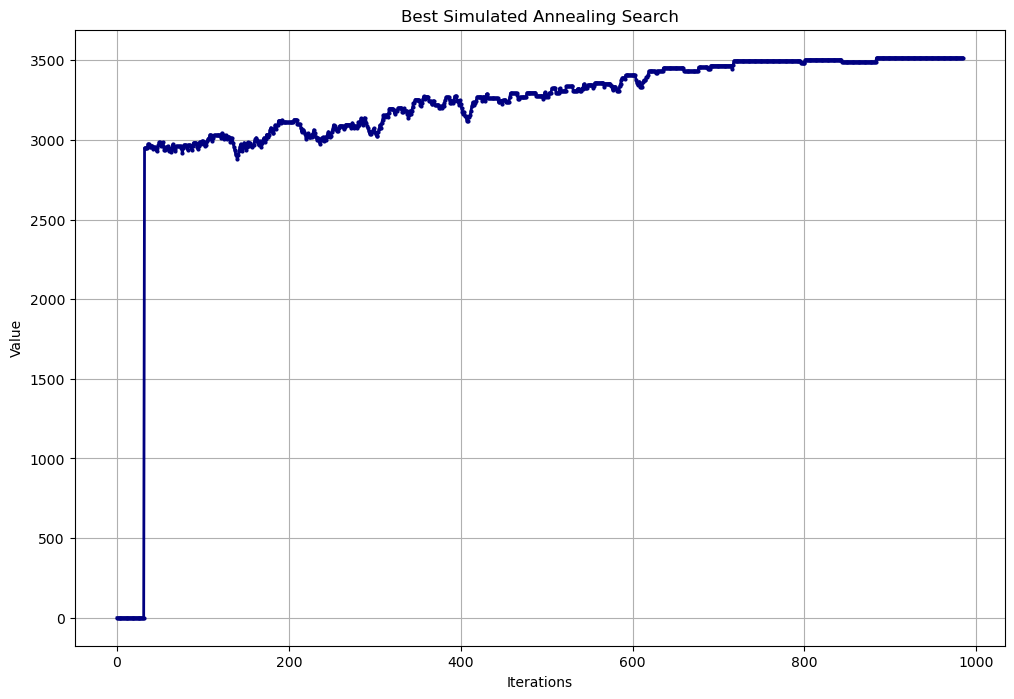

In [15]:
ax = best_curve.Fitness.plot(lw=2, colormap='jet', marker='o', markersize=2, 
                             figsize=(12,8), grid=1,
                             title='Best Simulated Annealing Search')
ax.set_xlabel("Iterations")
ax.set_ylabel("Value")

In [16]:
%%time
gen_alg = mlrose_hiive.GARunner(problem=problem,
                          experiment_name="gen_alg",
                          seed=seed,
                          iteration_list=iteration_list,
                          max_attempts=max_attempts,
                          population_sizes=[50, 200, 500, 1000],
                          mutation_rates=[0.1, 0.25, 0.5, 0.75])
ga_run_stats, ga_run_curves = gen_alg.run() 

CPU times: total: 1min 1s
Wall time: 1min 10s


In [23]:
final_iterations = ga_run_stats[ga_run_stats.Iteration != 0].reset_index()


print(final_iterations.Fitness.max(), final_iterations.Fitness.mean(), final_iterations.Time.mean())
print(final_iterations.groupby("Mutation Rate").Fitness.mean())
print(final_iterations.groupby("Population Size").Fitness.mean())
print(final_iterations.groupby("Population Size").Time.mean())

4204.956732201425 4108.211262383422 7.872047455554518
Mutation Rate
0.10    4063.684573
0.25    4096.001723
0.50    4164.947491
Name: Fitness, dtype: float64
Population Size
50     3925.324570
200    4194.536296
500    4204.772921
Name: Fitness, dtype: float64
Population Size
50      1.966495
200     5.854848
500    15.794799
Name: Time, dtype: float64


Text(0, 0.5, 'Time in Seconds')

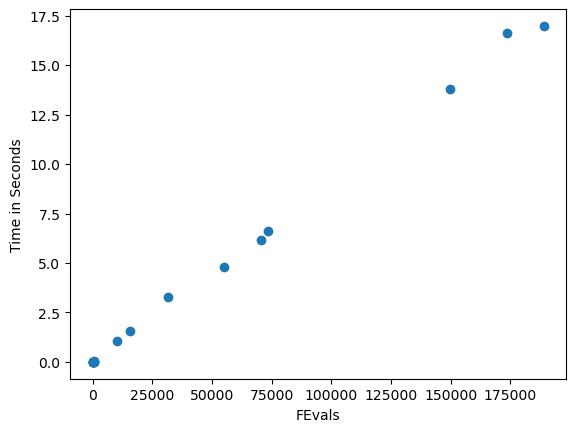

In [18]:
plt.scatter(x=ga_run_stats['FEvals'], y=ga_run_stats['Time'])
plt.xlabel("FEvals")
plt.ylabel("Time in Seconds")

In [19]:
%%time
mimic = mlrose_hiive.MIMICRunner(problem=problem, experiment_name="mimic", seed=seed,
                  iteration_list=iteration_list, max_attempts=200,
                  population_sizes=[50, 200, 500, 1000], keep_percent_list=[0.10, 0.25, 0.5, 0.75], use_fast_mimic=True)

# the two data frames will contain the results
mmc_run_stats, mmc_run_curves = mimic.run()

CPU times: total: 1h 21min 39s
Wall time: 1h 33min 56s


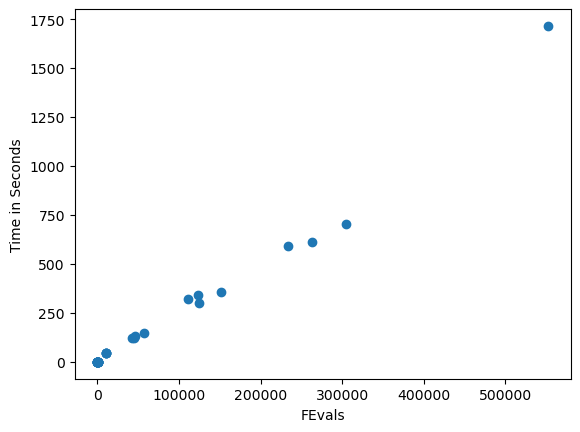

In [20]:
plt.scatter(x=mmc_run_stats['FEvals'], y=mmc_run_stats['Time'])
plt.xlabel("FEvals")
plt.ylabel("Time in Seconds")
plt.show()

In [21]:
final_iterations = mmc_run_stats[mmc_run_stats.Iteration != 0].reset_index()
print("Max and mean")
print(final_iterations.Fitness.max(), final_iterations.Fitness.mean(), final_iterations.Time.mean())
print(final_iterations.groupby("Keep Percent").Fitness.mean())
print(final_iterations.groupby("Population Size").Fitness.mean())
print(final_iterations.groupby("Population Size").Time.mean())

Max and mean
4193.345625289805 3676.7445076147624 352.23880930000087
Keep Percent
0.10    3737.632185
0.25    3870.762852
0.50    3846.385439
0.75    3252.197555
Name: Fitness, dtype: float64
Population Size
50      3122.740404
200     3714.509433
500     3903.471546
1000    3966.256647
Name: Fitness, dtype: float64
Population Size
50       44.708793
200     130.295586
500     329.200469
1000    904.750388
Name: Time, dtype: float64
